In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_training_data = pd.DataFrame.from_csv("/workspace/notebooks_data/training_set.csv")

In [3]:
# Read and return the Saxon test set 
def fetch_testing_data():
    df = pd.DataFrame.from_csv("data/proteasomal_cleavage/s6_in_vivo_mhc_1_ligands_dataset.csv")
    df = df[["Sequences", "Activity"]]
    df.columns = ["sequence", "is_cleaved"]
    df.is_cleaved[df.is_cleaved == -1] = 0
    return df

raw_testing_data = fetch_testing_data()

In [4]:
from aa_props import seq_to_aa_props
from sklearn.preprocessing import MinMaxScaler

# We need to remove the Saxova samples from our training set
print "There are %d training samples before removing the Saxova sequences." % (
    raw_training_data.shape[0])
raw_training_data = raw_training_data[raw_training_data.sequence.isin(
    raw_testing_data.sequence) == False]
print "There are %d training samples after filtering out Saxova." % (
    raw_training_data.shape[0])

# Filter to check for selenocysteine (TODO) and an invalid "'"
train_seq_validator = lambda seq: seq.find("U") == -1 and seq.find("'") == -1
# Testing set has two sample which are not the correct len, filter them out too
test_seq_validator = lambda seq: train_seq_validator(seq) and len(seq) == 28

process_raw_data = lambda data, is_valid: [(seq_to_aa_props(seq), is_cleaved)
             for (i, seq, is_cleaved) in data.itertuples()
             if is_valid(seq)]

# Filter AA seqs and expand to AA features
scaler = MinMaxScaler()
training_X_y = process_raw_data(raw_training_data, train_seq_validator)
testing_X_y = process_raw_data(raw_testing_data, test_seq_validator)

(training_X, training_y) = zip(*training_X_y)
(testing_X, testing_y) = zip(*testing_X_y)

# Scale the data
scaler = MinMaxScaler()
training_X = scaler.fit_transform(training_X)
testing_X = scaler.transform(testing_X)

print "Final training set has %d samples of %d raw samples." % (
    training_X.shape[0], raw_training_data.shape[0])
print "Final testing set has %d samples of %d raw samples." % (
    testing_X.shape[0], raw_testing_data.shape[0])


There are 49138 training samples before removing the Saxova sequences.
There are 49116 training samples after filtering out Saxova.
Final training set has 49113 samples of 49116 raw samples.
Final testing set has 416 samples of 419 raw samples.


In [5]:
train_file = "/workspace/notebooks_data/training_data.ll"
test_file = "/workspace/notebooks_data/testing_data.ll"

def create_liblinear_files():
    for (outpath, rows) in [(train_file, zip(training_y, training_X)),
                            (test_file, zip(testing_y, testing_X))]:
        with open(outpath, 'w') as out:
            for (is_cleaved, features) in rows:
                out.write("%+d " % (is_cleaved))
                for (feature_id, feature_value) in enumerate(features):
                    out.write("%d:%s " % (feature_id + 1, feature_value))
                out.write("\n")

create_liblinear_files()

In [6]:
findC = !train -C -s 0 $train_file
print "\n".join(findC)

Doing parameter search with 5-fold cross validation.
log2c= -25.00	rate=69.4114
log2c= -24.00	rate=70.3744
log2c= -23.00	rate=72.5103
log2c= -22.00	rate=75.2306
log2c= -21.00	rate=77.7289
log2c= -20.00	rate=79.4678
log2c= -19.00	rate=80.3616
log2c= -18.00	rate=80.7444
log2c= -17.00	rate=81.0519
log2c= -16.00	rate=81.3471
log2c= -15.00	rate=81.795
log2c= -14.00	rate=82.3937
log2c= -13.00	rate=83.2142
log2c= -12.00	rate=84.1895
log2c= -11.00	rate=85.0651
log2c= -10.00	rate=85.8408
log2c=  -9.00	rate=86.6247
log2c=  -8.00	rate=87.2009
log2c=  -7.00	rate=87.6978
log2c=  -6.00	rate=87.9706
log2c=  -5.00	rate=88.3167
log2c=  -4.00	rate=88.4715
log2c=  -3.00	rate=88.5651
log2c=  -2.00	rate=88.5651
log2c=  -1.00	rate=88.5651
log2c=   0.00	rate=88.5651
Best C = 0.125  CV accuracy = 88.5651%


In [7]:
bestC = findC[-1].split(" ")[3]
print "Using C=%s to create the model from %s" % (bestC, train_file)
createModel = !train -c {bestC} -s 0 {train_file} {train_file}.model
print "\n".join(createModel)

Using C=0.125 to create the model from /workspace/notebooks_data/training_data.ll
iter  1 act 1.970e+03 pre 1.720e+03 delta 2.282e+00 f 4.255e+03 |g| 2.572e+03 CG   5
cg reaches trust region boundary
iter  2 act 4.260e+02 pre 3.497e+02 delta 2.945e+00 f 2.286e+03 |g| 8.400e+02 CG  10
cg reaches trust region boundary
iter  3 act 1.437e+02 pre 1.224e+02 delta 3.599e+00 f 1.860e+03 |g| 2.736e+02 CG  12
cg reaches trust region boundary
iter  4 act 4.423e+01 pre 4.098e+01 delta 3.913e+00 f 1.716e+03 |g| 8.934e+01 CG  24
iter  5 act 1.900e+00 pre 1.863e+00 delta 3.913e+00 f 1.672e+03 |g| 3.556e+01 CG  23


In [8]:
notebooks_data = "/workspace/notebooks_data/"
prediction_file = notebooks_data + "predictions.txt"
%cd $notebooks_data
predict = !predict -b 1 testing_data.ll training_data.ll.model {prediction_file}
"\n".join(predict)
%cd /workspace/notebooks/

/Users/matt/workspace/notebooks_data
/Users/matt/workspace/notebooks


             precision    recall  f1-score   support

          0       0.83      0.76      0.79       208
          1       0.78      0.84      0.81       208

avg / total       0.80      0.80      0.80       416

MCC = 0.61


<IPython.core.display.Javascript object>


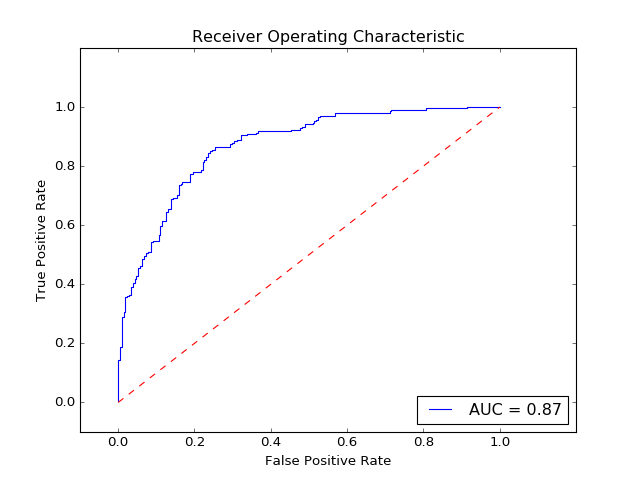

In [9]:
def fetch_prediction_regression():
    predictions = []
    with open(prediction_file, "r") as input:
        for line in input.readlines()[1:]:
            predictions.append(float(line.split(" ")[1]))
    return predictions

def fetch_prediction_classification():
    predictions = []
    with open(prediction_file, "r") as input:
        for line in input.readlines():
            predictions.append(int(line))
    return predictions

predictions = fetch_prediction_regression()
from sklearn.metrics import classification_report, matthews_corrcoef
pred_cutoff = 0.4
classification_vector = [1 if pred > pred_cutoff else 0 for pred in predictions]
print classification_report(testing_y, classification_vector)
print "MCC = %.2f" % (matthews_corrcoef(testing_y, classification_vector))

%matplotlib notebook
from util.roc_curve import roc_curve
plt = roc_curve(testing_y, predictions)
plt.show()



TODO: use trainging_data_scale to generate C matrix for AA features